## Sentence Transformers Finetuning

ref: https://www.sbert.net/ <br>

ref: https://www.sbert.net/docs/training/overview.html        

Data Folder: https://drive.google.com/drive/folders/1Q9prRy02buQ09X5RDia-KMO1G19qPwws?usp=sharing

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
from sentence_transformers import InputExample, models, SentenceTransformer, losses
from torch.utils.data import DataLoader
from sentence_transformers.cross_encoder import CrossEncoder
import pandas as pd
import torch
import random
import ast

import itertools

import re
import numpy as np
import nltk
import gc
import datasets
import pickle

In [3]:
torch.cuda.is_available()

True

In [6]:
# Dataset Ref:
# https://huggingface.co/datasets/fabiochiu/medium-articles
data = datasets.load_dataset('fabiochiu/medium-articles', data_files= 'medium_articles.csv')

# converting the dataset_dictionary object to pandas dataframe
data = pd.DataFrame.from_dict(data['train'])

Using custom data configuration fabiochiu--medium-articles-96791ff68926910d
Reusing dataset csv (C:\Users\Sridhar Kamoji\.cache\huggingface\datasets\fabiochiu___csv\fabiochiu--medium-articles-96791ff68926910d\0.0.0\652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
data = data.sample(n = 5000, random_state=32)

data.reset_index(drop = True, inplace = True)

In [14]:
data['train_text'] = data['title'] + '. ' + data['text']

In [24]:
data['train_text_sent_tokenized'] = [pd.DataFrame(nltk.sent_tokenize(txt), columns= ['Sentence_1']) for txt in data['train_text']]

In [34]:
dt_list = []
for dt in data['train_text_sent_tokenized']:
    dt['Sentence_2'] = dt['Sentence_1'].shift(-1)
    dt_list.append(dt)

In [57]:
# [dt.dropna(inplace = True) for dt in dt_list]
sent_pair_df = pd.concat(dt_list)

In [58]:
sent_pair_df.shape

(216472, 2)

In [59]:
sent_pair_df = sent_pair_df.sample(n = 40000, random_state=32)

In [41]:
cross_en = CrossEncoder("pinecone/bert-mrpc-cross-encoder")

In [60]:
scores = cross_en.predict(list(zip(sent_pair_df['Sentence_1'].tolist(), sent_pair_df['Sentence_2'].tolist())))

In [61]:
sent_pair_df['CrossEncScores'] = scores

In [62]:
sent_pair_df.head()

,Sentence_1,Sentence_2,CrossEncScores
39,Devote ample reading time outside the textbooks.,TangoRisto (iOS/Google Play) and Satori Reader...,0.153791
116,I was also lucky enough to see him live at my ...,"However, I didn’t care for his major label deb...",0.175978
1,The remains of an ancient fortress dating back...,The historical ruins were found in Rivi area i...,0.442764
17,I got first-hand experience working in an emer...,That’s also where I met my wife.,0.264968
189,"By the end of 2010, both the JTSB and NTSB had...",Were MD-11 pilots losing their touch?,0.182762


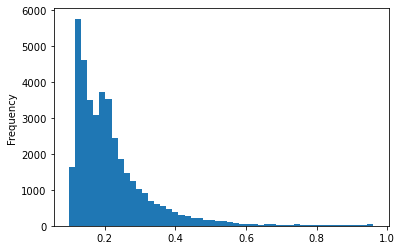

In [63]:
sent_pair_df['CrossEncScores'].plot(kind = 'hist', bins=  50)

In [64]:
sent_pair_df.to_csv('MediumArticlesSentencePairs.csv')

In [65]:
sent_pair_df[sent_pair_df['CrossEncScores'] >= 0.5].shape

(1189, 3)

In [66]:
sent_pair_df = sent_pair_df[sent_pair_df['CrossEncScores'] >= 0.5]

In [68]:
from sklearn.model_selection import train_test_split

In [72]:
nbins = 50
bins = np.linspace(0, 1, nbins)

y_binned = np.digitize(sent_pair_df['CrossEncScores'], bins)

X_train, X_val, y_train, y_val = train_test_split(sent_pair_df[['Sentence_1','Sentence_2']], sent_pair_df['CrossEncScores'], 
                                                  test_size=0.1, stratify=y_binned)

In [73]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [75]:
sent_pair_df.shape
train_data.shape
val_data.shape

(1189, 3)

(1070, 3)

(119, 3)

In [78]:
final_train_data = []
for ind, rec in train_data.iterrows():
    final_train_data.append(InputExample(texts=[rec['Sentence_1'], rec['Sentence_2']], 
                                   label= float(rec['CrossEncScores'])))
final_val_data = []
for ind, rec in val_data.iterrows():
    final_val_data.append(InputExample(texts=[rec['Sentence_1'], rec['Sentence_2']], 
                                   label= float(rec['CrossEncScores'])))

final_data = []
for ind, rec in sent_pair_df.iterrows():
    final_data.append(InputExample(texts=[rec['Sentence_1'], rec['Sentence_2']], 
                                   label= float(rec['CrossEncScores'])))

In [79]:
len(final_data)
len(final_train_data)
len(final_val_data)

1189

1070

119

In [80]:
batch_size = 2
final_loader = DataLoader(final_train_data, 
                          batch_size = batch_size, 
                          shuffle = True)

In [96]:
bert_model = models.Transformer('MediumArticlesDbertFineTuned', tokenizer_name_or_path = 'MediumArticlesDbertTokenizer')

Some weights of the model checkpoint at MediumArticlesDbertFineTuned were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [97]:
pooling = models.Pooling(bert_model.get_word_embedding_dimension(),
                         pooling_mode_mean_tokens=True)

model = SentenceTransformer(modules=[bert_model, pooling])

In [98]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [99]:
epochs = 5
warmup = int(len(final_train_data) * 0.1 * epochs)

In [101]:
bi_enc_path = './output/MediumArticlesMLM_SBert/'
loss = losses.MultipleNegativesRankingLoss(model)
# loss = losses.ContrastiveLoss(model)
# loss = losses.CosineSimilarityLoss(model)

## Evaluation of SBert model before training

### Train data eval

In [86]:
import sentence_transformers

In [87]:
train_evaluator = sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(train_data['Sentence_1'].tolist(),
                                                                  train_data['Sentence_2'].tolist(),
                                                                  train_data['CrossEncScores'],
                                                                         show_progress_bar=True)

In [88]:
# before training
model.evaluate(train_evaluator)

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

0.49757646041662257

### Validation data eval

In [90]:
evaluator = sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(val_data['Sentence_1'].tolist(),
                                                                  val_data['Sentence_2'].tolist(),
                                                                  val_data['CrossEncScores'],
                                                                         show_progress_bar=True)

In [91]:
# before training
model.evaluate(evaluator)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

0.4797535963537957

### Full data eval

In [93]:
full_evaluator = sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(sent_pair_df['Sentence_1'].tolist(),
                                                                  sent_pair_df['Sentence_2'].tolist(),
                                                                  sent_pair_df['CrossEncScores'],
                                                                         show_progress_bar=True)

In [94]:
model.evaluate(full_evaluator)

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

0.4906380815335361

In [102]:
hist = model.fit(train_objectives= [(final_loader, loss)],
                 evaluator=evaluator,
                  evaluation_steps = 300,
                  epochs= 5,
                 warmup_steps= warmup,
                 output_path=bi_enc_path,
                 show_progress_bar=True)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/535 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/535 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/535 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/535 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/535 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [107]:
model.best_score

0.5348563940912876

In [108]:
model = SentenceTransformer(bi_enc_path)

### Train data eval

In [109]:
train_evaluator = sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(train_data['Sentence_1'].tolist(),
                                                                  train_data['Sentence_2'].tolist(),
                                                                  train_data['CrossEncScores'],
                                                                         show_progress_bar=True)

In [110]:
# Post training
model.evaluate(train_evaluator)

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

0.4927714687137027

### Validation data eval

In [112]:
evaluator = sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(val_data['Sentence_1'].tolist(),
                                                                  val_data['Sentence_2'].tolist(),
                                                                  val_data['CrossEncScores'],
                                                                         show_progress_bar=True)

In [113]:
model.evaluate(evaluator)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

0.5348563940912876

### Full data eval

In [115]:
full_evaluator = sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(sent_pair_df['Sentence_1'].tolist(),
                                                                  sent_pair_df['Sentence_2'].tolist(),
                                                                  sent_pair_df['CrossEncScores'],
                                                                         show_progress_bar=True)

In [116]:
#post training
model.evaluate(full_evaluator)

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

0.49643395307117766

In [118]:
sent_emb = model.encode('hello')
sent_emb.shape
sent_emb

(768,)

array([-6.74863338e-01, -3.04354221e-01,  8.22055638e-01, -8.54788721e-01,
       -5.29420197e-01,  1.76503375e-01,  8.65956783e-01,  4.65393782e-01,
       -7.85416603e-01, -2.23744139e-01, -7.84071624e-01,  3.07584465e-01,
       -2.96236962e-01,  2.30749607e-01, -3.30212079e-02, -1.43616587e-01,
       -1.08410381e-01, -1.53092980e-01,  1.54544599e-03,  1.28806695e-01,
       -2.23232985e-01,  3.83336306e-01,  5.04706562e-01, -6.31260633e-01,
       -4.68208075e-01, -6.31641671e-02,  1.28709137e-01,  2.35222444e-01,
       -1.59306183e-01, -7.98875559e-03, -5.79685867e-01,  5.78516610e-02,
        2.19512239e-01, -4.02369909e-02, -8.55592728e-01, -3.87088098e-02,
       -5.19829631e-01,  2.78477430e-01, -7.12288380e-01,  2.06585661e-01,
        7.81767592e-02, -2.94445306e-01,  7.25288868e-01,  3.23601753e-01,
       -2.27860823e-01, -1.30788803e+00, -1.35001981e+00,  8.68126228e-02,
        1.72538012e-02, -3.85487169e-01,  3.13725650e-01,  5.74101269e-01,
       -1.36371344e-01,  